In [1]:
from sys import exit
import importlib

from astropy.io.votable import is_votable, parse
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from matplotlib.markers import MarkerStyle

from stage2 import *

# 1.DATA TREATMENT SECTION

## Checking that file format is correct

In [3]:
pathdata = "outputs/"
data     = ["matching_fieldGals_with_Zurich_acc_1_arcsec.vot", "master_field_galaxiesV2.vot"]

for name in data:
    voTag = is_VOtable(pathdata+name)
    if voTag:        
        fullFileName = pathdata + name
        #Retrieving the data
        table = parse(fullFileName)
        full  = table.get_first_table()
        
        print("Size of", name, "is", full.array.shape[0], "\n")
    else:
        exit("Exiting")

The file outputs/matching_fieldGals_with_Zurich_acc_1_arcsec.vot is a VOtable, right ? True
Size of matching_fieldGals_with_Zurich_acc_1_arcsec.vot is 190 

The file outputs/master_field_galaxiesV2.vot is a VOtable, right ? True
Size of master_field_galaxiesV2.vot is 545 



## Getting data

In [3]:
matchWithZurich = parse(pathdata+data[0]).get_first_table().array
fieldGals       = parse(pathdata+data[1]).get_first_table().array

#Checking that the matching procedure did not duplicate galaxies
checkDupplicates([matchWithZurich, fieldGals], names=["matching_fieldGals_with_Zurich_acc_1_arcsec.vot", "master_field_galaxiesV2.vot"])

#Converting to an astropy table for simplicity
tableMatch = Table(matchWithZurich)        
tableField = Table(fieldGals)

#Checking that the maximum angular separation is less than 1 arcsec in the matching tableMatch
print("Maximum separation is", str((Table(matchWithZurich)['Separation']*u.arcsec).max()) + ".")
print("Mean separation is", str(np.mean(Table(matchWithZurich)['Separation']*u.arcsec)) + ".")
print("Median separation is", str(np.median(Table(matchWithZurich)['Separation']*u.arcsec)) + ".")
print("1st quantile is", str(np.quantile(Table(matchWithZurich)['Separation'], 0.25)*u.arcsec) + ".")
print("3rd quantile is", str(np.quantile(Table(matchWithZurich)['Separation'], 0.75)*u.arcsec) + ".\n")

#Remove galaxies which have wrong ID_Laigle_16 values (9999)
tableMatch = tableMatch[tableMatch['ID_Laigle_16'] != 9999]
tableField = tableField[tableField['ID_Laigle_16'] != 9999]

findWhereIsValue([tableMatch['ID_Laigle_16'], tableField['ID_Laigle_16']], 9999)

#Remove the galaxy counted twice in the array
arr, indices = np.unique(tableField['ID_Laigle_16'], return_index=True)
tableField   = tableField[indices]

print("\nNumber of galaxies in matching catalog:", np.shape(tableMatch)[0], 
      "\nNumber of galaxies in field catalog:", np.shape(tableField)[0])

#Split between galaxies with morphological data and without
mask              = np.in1d(tableField['ID_Laigle_16'], tableMatch['ID_Laigle_16'], assume_unique=True, invert=True)
galsWithoutMorpho = tableField[mask]

#Checking we have the right amount of galaxies
print("Number of gals without morpho:", np.shape(galsWithoutMorpho)[0],
      "\nNumber of gals with morpho + number without = initial total number ?", 
      np.shape(tableField)[0]==(np.shape(galsWithoutMorpho)[0]+np.shape(tableMatch)[0]))

All the galaxies are only listed once in the catalog matching_fieldGals_with_Zurich_acc_1_arcsec.vot
RA = 150.053047 deg and DEC = 2.604346 deg galaxy (line 6) is present more than once in catalog master_field_galaxiesV2.vot
RA = 150.053047 deg and DEC = 2.604346 deg galaxy (line 70) is present more than once in catalog master_field_galaxiesV2.vot
Maximum separation is 0.8778970454248154 arcsec.
Mean separation is 0.10395451693170249 arcsec.
Median separation is 0.06814922333003948 arcsec.
1st quantile is 0.04285471659041162 arcsec.
3rd quantile is 0.12246327531669089 arcsec.

No value 9999 found within array number 0
No value 9999 found within array number 1

Number of galaxies in matching catalog: 184 
Number of galaxies in field catalog: 489
Number of gals without morpho: 305 
Number of gals with morpho + number without = initial total number ? True


## Remove nan values

In [4]:
m                 = maskToRemoveVal([galsWithoutMorpho['lsfr']], astroTableMask=True)
galsWithoutMorpho = applyMask([galsWithoutMorpho], m)

m                 = maskToRemoveVal([tableMatch['lsfr']], astroTableMask=True)
tableMatch        = applyMask([tableMatch], m)

findWhereIsValue([galsWithoutMorpho['lsfr'], tableMatch['lsfr']])

No nan was found in array number 0
No nan was found in array number 1


## Plotting log(SFR) against log(mass)

Data from matching catalog
Without correction: scatter = 1.2970091918676652 dex
With correction: scatter = 1.2137403150044448 dex

Data from MUSE catalog
Without correction: scatter = 1.3085576918053483 dex
With correction: scatter = 1.2303555393867245 dex


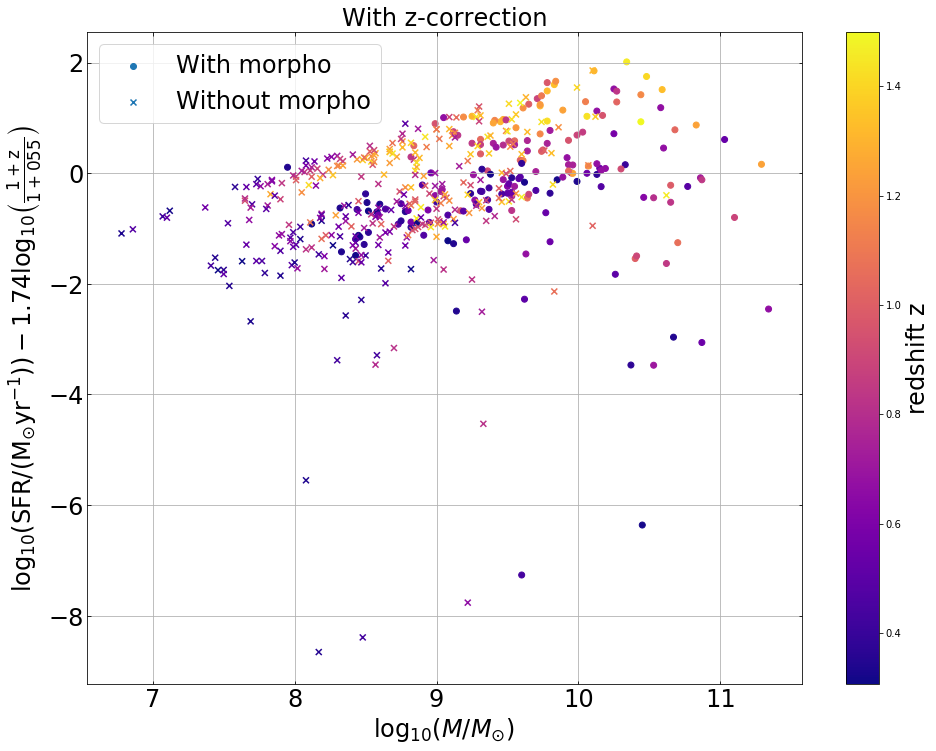

In [13]:
plt.rcParams["figure.figsize"] = (16, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

#custom color map for gals with morpho
newcmap, norm = from_levels_and_colors([0.5, 1.5, 2.5, 3.5], ['blue', 'green', 'red'])

cmin = np.min([np.min(tableMatch['Z_MUSE']), np.min(galsWithoutMorpho['Z_MUSE'])])
cmax = np.max([np.max(tableMatch['Z_MUSE']), np.max(galsWithoutMorpho['Z_MUSE'])])

# ax1, tmp = asManyPlots(121, [tableMatch['lmass'], galsWithoutMorpho['lmass']], 
#                        [tableMatch['lsfr'], galsWithoutMorpho['lsfr']],
#                        label=['With morpho', 'Without morpho'], showLegend=True,
#                        xlabel=r'$\log_{10} ( M/M_{\odot})$', ylabel=r'$\log_{10} (\rm{SFR}/(M_{\odot} \rm{yr}^{-1}))$',
#                        marker=['o', 'x'], zorder=[1, 2], 
#                        color=[tableMatch['Z_MUSE'], galsWithoutMorpho['Z_MUSE']], plotFlag=[False, False],
#                        cmapMin=cmin, cmapMax=cmax,
#                        cmap='plasma', title='Without z-correction')

# xdata = [0.83*(tableMatch['lmass']-1.0)+1.74*np.log10(1.0+tableMatch['Z_MUSE']), 
#          0.83*(galsWithoutMorpho['lmass']-1.0)+1.74*np.log10(1.0+galsWithoutMorpho['Z_MUSE'])]
ydata = [tableMatch['lsfr']-1.74*np.log10((1.0+tableMatch['Z_MUSE'])/1.55),
         galsWithoutMorpho['lsfr']-1.74*np.log10((1.0+galsWithoutMorpho['Z_MUSE'])/1.55)]
ax1, tmp = asManyPlots(111, [tableMatch['lmass'], galsWithoutMorpho['lmass']], 
                       ydata, 
                       ylabel=r'$\log_{10} (\rm{SFR}/(M_{\odot} \rm{yr}^{-1})) - 1.74 \log_{10} \left ( \frac{1+z}{1+055} \right )$',
                       xlabel=r'$\log_{10} ( M/M_{\odot})$',
                       marker=['o', 'x'], zorder=[1, 2], colorbarLabel=r'$\rm{redshift \,\, z}$',
                       cmapMin=cmin, cmapMax=cmax, showColorbar=True, plotFlag=[False, False],
                       color=[tableMatch['Z_MUSE'], galsWithoutMorpho['Z_MUSE']],
                       cmap='plasma', title='With z-correction', 
                       label=['With morpho', 'Without morpho'], showLegend=True)

print("Data from matching catalog\nWithout correction: scatter =", np.std(tableMatch['lsfr']), 
      "dex\nWith correction: scatter =", np.std(tableMatch['lsfr']-1.74*np.log10((1.0+tableMatch['Z_MUSE'])/1.55)),
      "dex\n\nData from MUSE catalog\nWithout correction: scatter =", np.std(galsWithoutMorpho['lsfr']),
      "dex\nWith correction: scatter =", np.std(galsWithoutMorpho['lsfr']-1.74*np.log10((1.0+galsWithoutMorpho['Z_MUSE'])/1.55)),
      "dex")

# plt.savefig('Plots/SFR_versus_mass.pdf')
# plt.savefig('Plots/SFR_versus_mass_zCorrectedOnly.pdf')

# 2.Building a table of field gals with Cassata and/or Zurich half-light radius counterpart and adding a new column which is either Zurich radius or bias corrected Cassata radius

In [4]:
pathdata = "outputs/"
data     = ["matching_fieldGals_with_Cassata_and_Zurich_acc_1_arcsec.vot", 
            "matching_fieldGals_with_Cassata_acc_1_arcsec.vot"]

#Checking that file format is correct
for name in data:
    voTag = is_VOtable(pathdata+name)
    if voTag:        
        fullFileName = pathdata + name
        #Retrieving the data
        table = parse(fullFileName)
        full  = table.get_first_table()
        
        print("Size of", name, "is", full.array.shape[0], "\n")
    else:
        exit("Exiting")

The file outputs/matching_fieldGals_with_Cassata_and_Zurich_acc_1_arcsec.vot is a VOtable, right ? True


Size of matching_fieldGals_with_Cassata_and_Zurich_acc_1_arcsec.vot is 186 

The file outputs/matching_fieldGals_with_Cassata_acc_1_arcsec.vot is a VOtable, right ? True


Size of matching_fieldGals_with_Cassata_acc_1_arcsec.vot is 298 



## Getting data

In [5]:
matchWithCassata       = parse(pathdata+data[1]).get_first_table().array
matchWithZurichCassata = parse(pathdata+data[0]).get_first_table().array

#Checking that the matching procedure did not duplicate galaxies
checkDupplicates([matchWithZurichCassata, matchWithCassata], 
                 names=["matching_fieldGals_with_Cassata_and_Zurich_acc_1_arcsec.vot", 
                        "matching_fieldGals_with_Cassata_acc_1_arcsec.vot"])

All the galaxies are only listed once in the catalog matching_fieldGals_with_Cassata_and_Zurich_acc_1_arcsec.vot
All the galaxies are only listed once in the catalog matching_fieldGals_with_Cassata_acc_1_arcsec.vot


In [6]:
#Converting to an astropy table for simplicity
tableMatchBoth = Table(matchWithZurichCassata)        
tableMatchCass = Table(matchWithCassata)

#Checking that the maximum angular separation is less than 1 arcsec in the matching tables
printSimpleStat([tableMatchBoth['Separation_ZURICH'], tableMatchCass['Separation_CASSATA']])

#Remove galaxies which have wrong ID_Laigle_16 values (9999)
tableMatchBoth = tableMatchBoth[tableMatchBoth['ID_Laigle_16'] != 9999]
tableMatchCass = tableMatchCass[tableMatchCass['ID_Laigle_16'] != 9999]

findWhereIsValue([tableMatchCass['ID_Laigle_16'], tableMatchBoth['ID_Laigle_16']], 9999)

#Remove the galaxy counted twice in the arrays
uniqueArr([tableMatchBoth, tableMatchCass], [tableMatchBoth['ID_Laigle_16'], tableMatchCass['ID_Laigle_16']])

print("\nNumber of galaxies in matching catalog with Cassata:", np.shape(tableMatchCass)[0], 
      "\nNumber of galaxies in matching catalog with Cassata & Zurich:", np.shape(tableMatchBoth)[0])

Stat for catalog number 0 :
Maximum separation is 0.8778970454248154.
Mean separation is 0.10371229092642334.
Median separation is 0.06769009751877036.
1st quantile is 0.042612085489821414.
3rd quantile is 0.12115790194733166.

Stat for catalog number 1 :
Maximum separation is 0.8768483517534824.
Mean separation is 0.10767987793148323.
Median separation is 0.0709917623259244.
1st quantile is 0.0429616639175216.
3rd quantile is 0.1264333202418157.



/home/wilfried/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


No value 9999 found within array number 0
No value 9999 found within array number 1

Number of galaxies in matching catalog with Cassata: 284 
Number of galaxies in matching catalog with Cassata & Zurich: 182


In [7]:
#Get a subtable with galaxies having Cassata radius only
mask            = np.in1d(tableMatchCass['ID_Laigle_16'], tableMatchBoth['ID_Laigle_16'], 
                        assume_unique=True, invert=True)
tableCassOnly   = tableMatchCass[mask]

#Keep list of fields which appear in Cassata+Zurich matching catalog but not in Cassata matching catalog
m               = np.in1d(tableMatchBoth.dtype.names, tableCassOnly.dtype.names, assume_unique=True, invert=True)
listFieldsToAdd = np.asarray(tableMatchBoth.dtype.names)[m]

#Adding Zurich columns (default value=-999) to the Table with galaxies in Cassata catalog only
sz = np.shape(tableCassOnly)[0]
for field in listFieldsToAdd:
    tableCassOnly[field] = np.array([-9999]*sz, dtype=tableMatchBoth.dtype[field])

#Correcting biais in Cassata radius
offset         = -3.495e-1
A              = 1.95e-3
R_half_CASSATA = tableCassOnly['R_HALF_CASSATA']/(1+offset+A*tableCassOnly['R_HALF_CASSATA'])

#Creating new column in both tables
newField                 = 'Corrected_radius'
tableMatchBoth[newField] = tableMatchBoth['R50_ZURICH']
tableCassOnly[newField]  = R_half_CASSATA

## Concatenating tables

In [8]:
newTable = vstack([tableMatchBoth, tableCassOnly], join_type='exact')

## Writing the full table in a new file

In [12]:
path       = 'outputs/'
outputFile = 'master_custerGals_Cassata_and_Zurich_corrected_radius.vot'
write_array_to_vot(newTable, path+outputFile, isTable=True)